In [1]:
!pip install fastai==0.7.0 --no-deps
!pip install pandas_summary
!pip install sklearn_pandas
!pip install fastprogress==0.2.1
!pip install torch==0.4.1 torchvision==0.2.1
!pip install bcolz
!pip install opencv-python
!pip install graphviz
!pip install isoweek
!pip install tqdm
!pip install pyarrow
%load_ext autoreload
%autoreload 2

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from fastai.imports import *
#from fastai.tabular import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/home/ricco/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_raw= pd.read_csv('Train.csv', low_memory=False, parse_dates=['saledate'])

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [4]:
display_all(df_raw.tail().T)
#df_raw.head()

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [5]:
df_raw.SalePrice= np.log(df_raw.SalePrice)

In [6]:
m= RandomForestRegressor(n_jobs=1)

In [7]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [8]:
train_cats(df_raw)

In [9]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [10]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [11]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [12]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [13]:
!pip install pyarrow
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [14]:
df_raw= pd.read_feather('tmp/bulldozers-raw')

In [15]:
df, y, nas= proc_df(df_raw, 'SalePrice')

In [16]:
m= RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9881576569179604

In [17]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid=12000
n_trn=len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
x_train, x_valid=split_vals(df, n_trn)
y_train, y_valid=split_vals(y, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((389125, 66), (389125,), (12000, 66))

In [18]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res= [rmse(m.predict(x_train), y_train), rmse(m.predict(x_valid), y_valid), 
         m.score(x_train, y_train), m.score(x_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [19]:
m= RandomForestRegressor(n_jobs=-1)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 20min 6s, sys: 1.79 s, total: 20min 8s
Wall time: 1min 48s
[0.07565965364159649, 0.23367968387136445, 0.9880363548316377, 0.9024808545687159]


Speeding Up Things 

In [20]:
df_trn, y_trn, nas= proc_df(df_raw, 'SalePrice', subset=3000, na_dict=nas)
x_train,_ = split_vals(df_trn, 20000)
y_train,_ = split_vals(y_trn, 20000)

In [21]:
m=RandomForestRegressor(n_jobs=-1)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 4.97 s, sys: 23.7 ms, total: 4.99 s
Wall time: 538 ms
[0.12017334196463683, 0.3133103752977229, 0.9708829733408778, 0.8246936984013181]


Visualizing a single tree

In [22]:
m= RandomForestRegressor(n_estimators=1, max_depth= 3, bootstrap= False, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.5319151135629927, 0.5744345596214615, 0.4295528601286316, 0.41070996817860345]


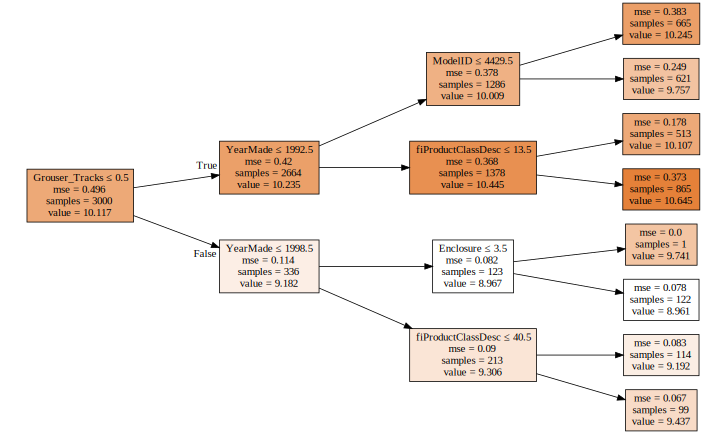

In [23]:
draw_tree(m.estimators_[0], df_trn, precision=3)


In [24]:
#creating a bigger tree
m= RandomForestRegressor(n_estimators = 1, bootstrap=False,n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.0, 0.4664385193733847, 1.0, 0.6114590567483915]


Bagging

In [25]:
m=RandomForestRegressor(n_jobs=-1)
m.fit(x_train,y_train)
print_score(m)

[0.12020703757872259, 0.31325637145847707, 0.9708666427033835, 0.8247541266422389]


In [26]:
preds=np.stack([t.predict(x_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.25913,  9.39266,  9.61581,  9.25913,  9.68034,  9.21034,  9.21034,  9.21034,  8.9359 ,  9.21034,
         9.71112,  9.74097,  8.9872 ,  8.9359 ,  9.21034,  9.25913,  9.3501 , 10.20359,  9.21034,  9.32812,
         9.3501 ,  8.9359 ,  9.21034,  9.68034, 10.20359,  9.3501 ,  9.30565,  8.9359 ,  8.9872 ,  8.9872 ,
         9.3501 ,  9.10498,  9.21034,  9.32812,  9.21034,  9.21034,  8.9872 ,  9.3501 ,  8.9359 ,  9.15905,
         9.15905,  9.39266,  9.61581,  9.21034,  8.92266,  8.9872 ,  9.10498,  9.3501 , 10.02127,  9.61581,
         9.32812,  9.43348,  9.21034,  8.9872 ,  9.10498,  9.92818,  9.10498,  9.61581,  9.10498,  9.61581,
         9.21034,  9.3501 ,  9.51044,  9.13238,  9.15905,  9.10498,  9.10498,  9.32812,  8.9872 , 10.20359,
         8.9872 ,  9.21034,  9.10498,  9.25913, 10.20359,  9.15905,  9.10498,  9.15905,  9.3501 , 10.30895,
         9.10498,  8.9359 ,  9.3501 ,  9.07681,  9.21034,  9.21034,  9.74097,  9.21034,  9.61581,  8.9872 ,
         8.9359 ,  9.43348, 

In [27]:
preds.shape

(100, 12000)

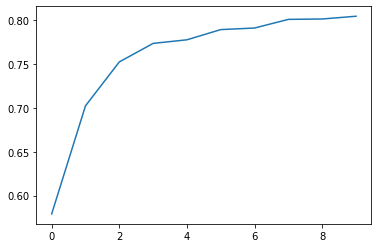

In [28]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

the graph show us that, as r2 increases in a logarithmic scale, adding more trees (estimators) isn't very helpful after some value

In [29]:
m=RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.13450073183273242, 0.32446210684704857, 0.9635262815682735, 0.8119921678499343]


In [30]:
m=RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.12475089652096409, 0.3186132460567051, 0.9686225174244842, 0.8187092571723964]


In [31]:
m=RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.12212678185077751, 0.3147532601268432, 0.9699286744183059, 0.8230753080154174]


OOB Score (Out-of-bag)

In [32]:
m=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.1243805640352624, 0.3165184047372731, 0.9688085337797275, 0.8210853470334687, 0.7722187057785207]


Reducing over-fitting

subsampling

In [33]:
df_trn, y_trn, nas= proc_df(df_raw, 'SalePrice')
x_train, x_valid= split_vals(df_trn, n_trn)
y_train, y_valid= split_vals(y_trn, n_trn)

In [34]:
set_rf_samples(20000)

In [35]:
m= RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 21min 14s, sys: 2.93 s, total: 21min 17s
Wall time: 2min 2s
[0.07574792800774817, 0.23405139814121542, 0.9880084218653851, 0.9021703604069083, 0.9129140409448618]


In [36]:
m= RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.07831593117886619, 0.23802699690027662, 0.9871815634435508, 0.8988186642185585, 0.9085322510448868]


tree building parameters

In [37]:
reset_rf_samples()

In [38]:
def dectree_max_depth(tree):
    children_left= tree.children_left
    children_right= tree.children_right
    
    def walk(node_id):
        if(children_left[node_id]!=children_right[node_id]):
            left_max= 1 + walk(children_left[node_id])
            right_max= 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else:#leaf
            return 1
    root_node_id = 0
    return walk(root_node_id)

In [39]:
m=RandomForestRegressor(n_estimators= 40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.07831899954233963, 0.23908605185219176, 0.9871805589890951, 0.8979162877458003, 0.9083635449158641]


In [40]:
t= m.estimators_[0].tree_

In [41]:
dectree_max_depth(t)

47

In [42]:
m= RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(x_train,y_train)
print_score(m)

[0.1406436947979487, 0.23474440259191157, 0.9586595347207115, 0.9015901737848857, 0.9070568392990628]


In [43]:
t=m.estimators_[0].tree_

In [44]:
dectree_max_depth(t)

34

In [45]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)


[0.11495367260632351, 0.233844047062346, 0.9723827438574338, 0.9023436223142073, 0.908481210681289]


In [46]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)


[0.11917812562259286, 0.22873478877719872, 0.9703156237518793, 0.9065643913774587, 0.9114615912940656]
